In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split #use this?
from scipy import stats

In [2]:
csvPath = r'D:\\Thesis2021\nba-movement-data\data\dataAndLabel'
#df = pd.read_csv('nba-movement-data\data\converted\0021500001_converted.csv')
df = pd.read_csv(csvPath + '/0021500001_dataAndLabel.csv')

games = os.listdir(csvPath)
all_files = glob.glob(os.path.join(csvPath, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files[0:15])
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

C:\Users\JCHam\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (82,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\JCHam\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DtypeWarning: Columns (82,84) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [3]:
#if we want all columns
pd.set_option('display.max_columns', 26)
df.head()

,game_clock,shot_clock,quarter,game_id,event_id,team_id1,player_id1,x_loc1,y_loc1,speed1,angle1,radius1,team_id2,...,radius11,isTO,isFT,isReb,isFTMade,FTsMade,NonShotPlayerID,NonShotPlayerName,ShotPlayerID,ShotPlayerName,SHOT_TIME,possPoints,isShot
0,720.00,24.00,1,21500001,1,-1,-1,11.4806,419.9969,0.000000,0.000000,6.76567,1610612737,...,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
1,719.98,23.90,1,21500001,1,-1,-1,26.8673,357.7526,0.000000,0.000000,6.47278,1610612737,...,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
2,719.94,23.86,1,21500001,1,-1,-1,25.1361,357.9653,43.605438,-0.122250,6.09299,1610612737,...,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
3,719.90,23.82,1,21500001,1,-1,-1,25.0770,355.3443,65.541656,1.548252,6.16468,1610612737,...,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
4,719.86,23.78,1,21500001,1,-1,-1,24.0813,353.8495,44.901597,0.983180,6.11854,1610612737,...,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False


In [6]:
def getDFReady(df):
    df = df.copy()
    df['possPoints'] = df.apply(lambda row: 0 if pd.isnull(row['possPoints']) else row['possPoints'],axis=1)
    df = df[['shot_clock','x_loc1','y_loc1','speed1','angle1','radius1','x_loc2','y_loc2','speed2','angle2','x_loc3','y_loc3','speed3','angle3',
            'x_loc4','y_loc4','speed4','angle4','x_loc5','y_loc5','speed5','angle5','x_loc6','y_loc6','speed6','angle6',
            'x_loc7','y_loc7','speed7','angle7','x_loc8','y_loc8','speed8','angle8','x_loc9','y_loc9','speed9','angle9',
            'x_loc10','y_loc10','speed10','angle10','x_loc11','y_loc11','speed11','angle11','possPoints']] #assumes player1 is always the ball
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X,y

In [96]:
X,y = getDFReady(concatenated_df)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=24) #can add shuffle=False to not shuffle

In [97]:
print("Overall Mean:", df.possPoints.mean())

Overall Mean: 0.7565712491794857


In [98]:
#train the xgboost model

dtrain = xgb.DMatrix(Xtrain,label=ytrain)

# from https://github.com/apple/coremltools/issues/605

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'multi:softprob',
    'num_class': 4,
    'booster' : 'gbtree', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.2,
    'gamma' : 5,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'max_depth': 4,
    'min_child_weight' : 6,
    'base_score' : ytrain.mean()
}

In [127]:
%%time 
xgb_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
xgb_model.save_model('xgbModel.json')
#print('time to train model is ',time.time() - start_time)

Wall time: 1h 11min 24s


In [128]:
%%time
#test the model

dtest = xgb.DMatrix(Xtest,label=ytest)
xgb_predictions = xgb_model.predict(dtest) #.tolist()

Wall time: 1min 18s


In [101]:
print(xgb_predictions)

[[6.43731058e-01 8.31337925e-03 2.14822918e-01 1.33132666e-01]
 [7.36778438e-01 6.17639907e-03 2.22934857e-01 3.41102742e-02]
 [3.67764562e-01 1.07807689e-03 6.06100917e-01 2.50564925e-02]
 ...
 [5.04774272e-01 1.55282706e-01 3.25290710e-01 1.46523174e-02]
 [8.71437192e-01 3.26274498e-03 1.06377684e-01 1.89223439e-02]
 [7.86878943e-01 1.37875395e-05 1.32233053e-01 8.08742195e-02]]


In [129]:
preds0,preds1,preds2,preds3 = xgb_predictions[:,0],xgb_predictions[:,1],xgb_predictions[:,2],xgb_predictions[:,3]
XtestCopy = Xtest.copy()
XtestCopy['x0Pts'] = preds0
XtestCopy['x1Pts'] = preds1
XtestCopy['x2Pts'] = preds2
XtestCopy['x3Pts'] = preds3
XtestCopy['EP'] = XtestCopy.apply(lambda row: row['x1Pts'] + 2*row['x2Pts'] + 3*row['x3Pts'],axis=1)
print('EP Mean vs. actual mean')
print(XtestCopy['EP'].mean())
print(ytest.mean())

EP Mean vs. actual mean
0.7516035461956172
0.7557897293256478


In [94]:
XtestCopy.sort_index().head()

,shot_clock,x_loc1,y_loc1,speed1,angle1,radius1,x_loc2,y_loc2,speed2,angle2,x_loc3,y_loc3,speed3,...,x_loc10,y_loc10,speed10,angle10,x_loc11,y_loc11,speed11,angle11,x0Pts,x1Pts,x2Pts,x3Pts,EP
2,23.86,25.1361,357.9653,43.605438,-0.122250,6.09299,91.7820,410.9989,9.409534,1.225771,41.6891,285.6228,45.780436,...,-105.0160,405.9587,5.817527,-1.705279,4.0251,413.8486,25.745054,2.205247,0.924893,0.013093,0.036110,0.025905,0.163027
3,23.82,25.0770,355.3443,65.541656,1.548252,6.16468,91.5735,410.5242,12.961779,1.156939,42.7647,284.3599,41.471615,...,-104.6349,406.8624,24.519264,-1.969878,4.8383,413.1746,26.405140,2.449521,0.910092,0.010390,0.044499,0.035019,0.204444
10,23.55,27.1564,341.2343,24.493343,-1.626023,6.27565,89.4298,403.3383,32.974032,1.318727,41.5697,280.3459,18.460849,...,96.7845,418.7759,73.464628,1.212449,8.5892,403.3360,33.121547,1.887143,0.929144,0.011683,0.041663,0.017510,0.147540
14,23.39,42.3933,344.2795,186.344898,-3.070751,5.99361,87.6133,395.5820,54.071210,1.372349,35.9798,280.7097,40.007743,...,91.3960,403.5149,107.012651,1.246364,11.3053,395.9387,55.016889,1.935928,0.890289,0.029778,0.049345,0.030588,0.220232
19,23.19,60.8936,339.7224,84.101090,2.485107,5.65287,86.2312,382.7766,72.327483,1.494125,27.1575,283.8277,50.062712,...,86.3343,383.4536,72.331912,1.417393,13.9894,384.7725,60.974148,1.718527,0.871043,0.010435,0.082913,0.035608,0.283086


In [130]:
cdf2 = concatenated_df[['game_clock','game_id','quarter']].copy()
graphData = XtestCopy.merge(cdf2,how='left',left_index=True,right_index=True)
graphData = graphData.loc[(graphData['game_id'] == 21500001) & (graphData['quarter'] == 1)]
graphData = graphData.sort_values(by=['game_clock'],ascending=False)
graphData = graphData[0:1000]

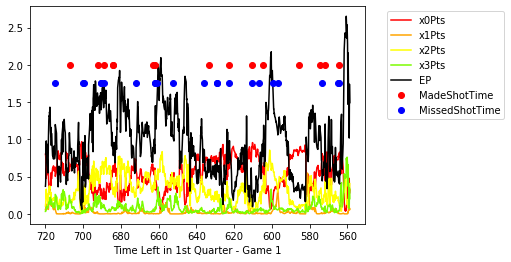

In [131]:
plt.figure()
plt.plot(graphData['game_clock'],graphData['x0Pts'],label='x0Pts',color='red')
plt.plot(graphData['game_clock'],graphData['x1Pts'],label='x1Pts',color='orange')
plt.plot(graphData['game_clock'],graphData['x2Pts'],label='x2Pts',color='yellow')
plt.plot(graphData['game_clock'],graphData['x3Pts'],label='x3Pts',color='lawngreen')
plt.plot(graphData['game_clock'],graphData['EP'],label='EP',color='black')
plt.plot(shotsSmall['SHOT_TIME'],[2 for i in range(len(shotsSmall))],marker='o',linestyle='none',color='red',label='MadeShotTime')
plt.plot(shotsSmallMissed['SHOT_TIME'],[1.75 for i in range(len(shotsSmallMissed))],marker='o',linestyle='none',color='blue',label='MissedShotTime')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gca().invert_xaxis()
plt.xlabel('Time Left in 1st Quarter - Game 1')
plt.show()

In [29]:
shotPath = 'nba-movement-data/data/shots'
shots = pd.read_csv(shotPath + '/shots_fixed.csv')
shots = shots.sort_values(by=['GAME_ID','GAME_EVENT_ID'])
shotsSmall = shots.loc[(shots['SHOT_TIME'] > 560) & (shots['GAME_ID'] == 21500001) & (shots['SHOT_MADE_FLAG'] == 1)]
shotsSmallMissed = shots.loc[(shots['SHOT_TIME'] > 560) & (shots['GAME_ID'] == 21500001) & (shots['SHOT_MADE_FLAG'] == 0)]
#shots.head()

# this model has no fts

In [39]:
noFTs = concatenated_df.loc[concatenated_df['isFT'] == 0].copy()
#noFTs has label for 2 points as 1 and label for 3 points as 2
noFTs['possPoints'] = noFTs.apply(lambda row: (row['possPoints'] - 1) if (row['possPoints'] != 0.0) else row['possPoints'],axis=1)

In [40]:
X,y = getDFReady(noFTs)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=24) #can add shuffle=False to not shuffle

In [41]:
noFTs['possPoints'].unique()

array([0., 1., 2.])

In [42]:
#train the xgboost model

dtrain = xgb.DMatrix(Xtrain,label=ytrain)

# from https://github.com/apple/coremltools/issues/605

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'booster' : 'gbtree', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.2,
    'gamma' : 5,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'max_depth': 4,
    'min_child_weight' : 6,
    'base_score' : ytrain.mean()
}

In [43]:
%%time 
xgb_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
xgb_model.save_model('xgbModelnoFT.json')
#print('time to train model is ',time.time() - start_time)

Wall time: 54min 34s


In [44]:
%%time
#test the model

dtest = xgb.DMatrix(Xtest,label=ytest)
xgb_predictions = xgb_model.predict(dtest) #.tolist()

Wall time: 8.06 s


In [45]:
print(xgb_predictions)

[[0.59562266 0.39642715 0.00795016]
 [0.67451984 0.10224842 0.22323175]
 [0.44209754 0.44799095 0.10991149]
 ...
 [0.95093656 0.0244003  0.02466317]
 [0.9196702  0.05904913 0.02128072]
 [0.7269305  0.24058178 0.0324877 ]]


In [46]:
preds0,preds1,preds2 = xgb_predictions[:,0],xgb_predictions[:,1],xgb_predictions[:,2]
XtestCopy = Xtest.copy()
XtestCopy['x0Pts'] = preds0
XtestCopy['x2Pts'] = preds1
XtestCopy['x3Pts'] = preds2
XtestCopy['EP'] = XtestCopy.apply(lambda row: 2*row['x2Pts'] + 3*row['x3Pts'],axis=1)
print('EP Mean vs. actual mean')
print(XtestCopy['EP'].mean())
ytest = ytest.apply(lambda row: (row + 1) if (row != 0.0) else row) #change values back to actual points
print(ytest.mean())

EP Mean vs. actual mean
0.7171176612354706
0.7183259504895774


In [47]:
cdf2 = df[['game_clock','game_id','quarter']].copy()
graphData = XtestCopy.merge(cdf2,how='left',left_index=True,right_index=True)
graphData = graphData.loc[(graphData['game_id'] == 21500001) & (graphData['quarter'] == 1)]
graphData = graphData.sort_values(by=['game_clock'],ascending=False)
graphData = graphData.loc[graphData['game_clock'] > 560]
#graphData = graphData[0:1000]

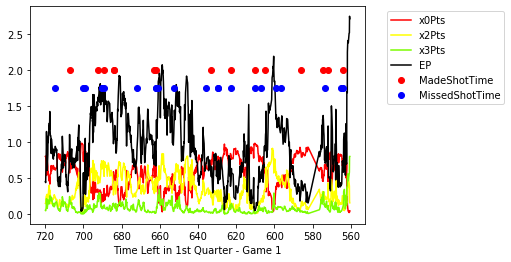

In [48]:
plt.figure()
plt.plot(graphData['game_clock'],graphData['x0Pts'],label='x0Pts',color='red')
plt.plot(graphData['game_clock'],graphData['x2Pts'],label='x2Pts',color='yellow')
plt.plot(graphData['game_clock'],graphData['x3Pts'],label='x3Pts',color='lawngreen')
plt.plot(graphData['game_clock'],graphData['EP'],label='EP',color='black')
plt.plot(shotsSmall['SHOT_TIME'],[2 for i in range(len(shotsSmall))],marker='o',linestyle='none',color='red',label='MadeShotTime')
plt.plot(shotsSmallMissed['SHOT_TIME'],[1.75 for i in range(len(shotsSmallMissed))],marker='o',linestyle='none',color='blue',label='MissedShotTime')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gca().invert_xaxis()
plt.xlabel('Time Left in 1st Quarter - Game 1')
plt.show()

In [31]:
# now use all df
dtestall = xgb.DMatrix(X)
xgb_predsall = xgb_model.predict(dtestall)

In [32]:
preds0,preds1,preds2 = xgb_predsall[:,0],xgb_predsall[:,1],xgb_predsall[:,2]
XCopy = X.copy()
XCopy['x0Pts'] = preds0
XCopy['x2Pts'] = preds1
XCopy['x3Pts'] = preds2
XCopy['EP'] = XCopy.apply(lambda row: 2*row['x2Pts'] + 3*row['x3Pts'],axis=1)
print('EP Mean vs. actual mean')
print(XCopy['EP'].mean())
yallCopy = y.copy()
yallCopy = yallCopy.apply(lambda row: (row + 1) if (row != 0.0) else row) #change values back to actual points
print(ytest.mean())

EP Mean vs. actual mean
0.7457723087232694
0.7570000584556029


In [37]:
cdf2 = df[['game_clock','game_id','quarter']].copy()
graphData = XCopy.merge(cdf2,how='left',left_index=True,right_index=True)
graphData = graphData.loc[(graphData['game_id'] == 21500001) & (graphData['quarter'] == 1)]
graphData = graphData.sort_values(by=['game_clock'],ascending=False)
graphData = graphData.loc[graphData['game_clock'] > 560]
#graphData = graphData[0:1000]

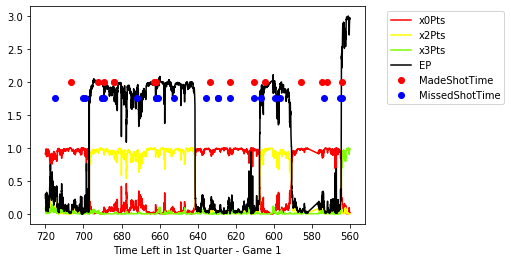

In [38]:
plt.figure()
plt.plot(graphData['game_clock'],graphData['x0Pts'],label='x0Pts',color='red')
plt.plot(graphData['game_clock'],graphData['x2Pts'],label='x2Pts',color='yellow')
plt.plot(graphData['game_clock'],graphData['x3Pts'],label='x3Pts',color='lawngreen')
plt.plot(graphData['game_clock'],graphData['EP'],label='EP',color='black')
plt.plot(shotsSmall['SHOT_TIME'],[2 for i in range(len(shotsSmall))],marker='o',linestyle='none',color='red',label='MadeShotTime')
plt.plot(shotsSmallMissed['SHOT_TIME'],[1.75 for i in range(len(shotsSmallMissed))],marker='o',linestyle='none',color='blue',label='MissedShotTime')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gca().invert_xaxis()
plt.xlabel('Time Left in 1st Quarter - Game 1')
plt.show()

\\(EP = 0*x0Points + 1*x1Points + 2*x2Points + 3*x3Points\\)

\\(M_1(x) \Leftarrow  M_0(x) + R_1(x)\\)

\\(M_2(x) \Leftarrow  M_1(x) + R_2(x)\\)

\\(\vdots\\)

\\(M_n(x) \Leftarrow  M_{n-1}(x) + R_n(x)\\)